# Expected Value of Cost function in population setting

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Generate $n$D Data

In [2]:
def generate_data_nD(length, n, A):
    
    # Initialize series
    series = np.array(np.zeros((length, n)))
    
    inv_P = np.linalg.inv(P)
    
    # Generate series
    for t in range(1, length):
        # Generate VAR model
        series[t] = np.matmul(inv_P, np.matmul(A, np.matmul(P, series[t - 1])) + np.random.multivariate_normal(np.zeros(n), Sigma))
    
    return series

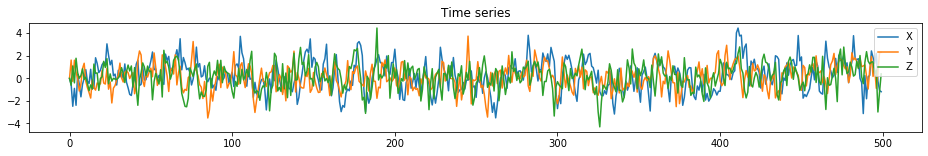

[[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.3 0.6]]


In [3]:
np.random.seed(seed = 1)

length, n = 500, 3
A, P, Sigma = None, None, None 

if n == 2:
    A = np.array([[0.4, 0.9], [0.1, 0.4]])
    P = np.array([[1.0, 0.0], [0.0, 1.0]])
    Sigma = np.identity(n)
elif n == 3:
    A = np.array([[0.5, 0.0, 0.0], [0.3, 0.4, 0.0], [0.2, 0.3, 0.6]])
    Sigma = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    P = np.array([[0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0]])
    # A = np.round(np.random.rand(n, n) / 2, 2)
    
elif n == 4:
    
    P = np.array([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0.0]])

# Generate nD data
series = generate_data_nD(length, n, A)

# Plot
plt.figure(figsize=(16,2))
plt.title("Time series")
plots = plt.plot(series)
plt.legend(plots, ["X", "Y", "Z"], loc=1)
plt.show()

As, Ps = A.copy(), P.copy()

print(A)

# Cost Function
$$C(A, P, A^*, P^*) = \left\lVert X_{t, val} - X_{t,pred}\right\rVert_2^2,$$
where we use the following value to predict $X_t$:
$$X_{t,pred} = P^{-1}APX_{t-1}$$
In reality, there is some underlying $P^*$, $A^*$ used to generate $X_{t,val}:$
$$X_{t, val} = P^{*-1}A^*P^*X_{t-1} + \Sigma.$$

This means that the cost function is 
$$C(A, P, A^*, P^*) = \left\lVert P^{*-1}A^*P^*X_{t-1} + \Sigma- P^{-1}APX_{t-1}\right\rVert_2^2,$$

## Distribution of $X$
We assume that $X_1 \sim \mathcal{N}\left(\mathbf{0}, \Sigma\right)$. Then, the distribution of $X_t$, where $t$ can be any integer, will be

$$X_t \sim \mathcal{N}\left(0, \Sigma_X\right),$$

where $$\text{vec}(\Sigma_X) = \left(I_{n^2} - B^* \otimes B^*\right)^{-1} \text{vec}(\Sigma),$$

and $$B^* = P^{*-1} A^* P^*.$$

More specifically, we have

$$\Sigma_X = \left(\text{vec}\left(I_n\right)^T \otimes I_m\right)\left(I_n \otimes \text{vec}(\Sigma_X) \right).$$

In [4]:
def expected_cost(A, P, As = As, Ps = Ps):
    # base on the distribution of X, no actual data needed.
    # we need the covariance of X_t - X_{t-1}.
    # Then, the expected cost is the trace of this covariance
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    
    covariance_matrix = Sigma + np.matmul((Bs - B), np.matmul(covariance_X, (Bs - B).transpose()))
    
    return np.trace(covariance_matrix)

In [5]:
def expected_cost_2(A, P, As = As, Ps = Ps):
    # base on the distribution of X, no actual data needed.
    # we need the covariance of X_t - X_{t-1}.
    # Then, the expected cost is the trace of this covariance
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.tril(np.matmul(P_inv, np.matmul(A, P)))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    
    covariance_matrix = Sigma + np.matmul((Bs - B), np.matmul(covariance_X, (Bs - B).transpose()))
    
    return np.trace(covariance_matrix)

We see that the analytic approach and the data sampling approach yield almost identical results, with the data sampling approach converging to the analytic approach when we take an infinite amount of samples.
## Expected cost when using $P^*$ and $A^*$
\begin{align*}\mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right] &= \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right) \\
&= \text{Tr}\left(\Sigma + \left(B^* - B^*\right)\Sigma_X\left(B^* - B^*\right)^T\right) \\
&= \text{Tr}\left(\Sigma\right).
\end{align*}
Hence, we see that we achieve the minimum for $P^*$ and $A^*$.

In [6]:
def C_n(A = As, P = Ps):
    """
    Given that series has been generated according to P*, A*,
    This function returns the cost when using estimates P, A.
    """
    
    cost = 0

    P_inv = np.linalg.inv(P)

    for t in range(1, length):
        val = series[t]
        est = np.matmul(P_inv, np.matmul(A, np.matmul(P, series[t - 1])))
        cost += np.linalg.norm(val - est) ** 2

    return cost / (length - 1)

print("Expected Cost when using P* and A*:", np.trace(Sigma))
print("Expected Cost when using P* and A*:", expected_cost(As, Ps))
print("Cost from data when using P* and A*:", round(C_n(), 3))

Expected Cost when using P* and A*: 3.0
Expected Cost when using P* and A*: 3.0
Cost from data when using P* and A*: 2.973


In [7]:
print("Expected Cost when using P* and A* full rank:", np.trace(Sigma))

import itertools
P_list = np.array(list(itertools.permutations(np.identity(n))))

for i in range(len(P_list)):
    print(np.tril(np.matmul(P_list[i], A)))
    print("Expected Cost when using A:", expected_cost_2(A, np.array(P_list[i])))

Expected Cost when using P* and A* full rank: 3.0
[[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.3 0.6]]
Expected Cost when using A: 3.64827537593985
[[0.5 0.  0. ]
 [0.2 0.3 0. ]
 [0.3 0.4 0. ]]
Expected Cost when using A: 3.657297932330827
[[0.3 0.  0. ]
 [0.5 0.  0. ]
 [0.2 0.3 0.6]]
Expected Cost when using A: 3.669819078947368
[[0.3 0.  0. ]
 [0.2 0.3 0. ]
 [0.5 0.  0. ]]
Expected Cost when using A: 3.209761904761905
[[0.2 0.  0. ]
 [0.5 0.  0. ]
 [0.3 0.4 0. ]]
Expected Cost when using A: 3.71906719924812
[[0.2 0.  0. ]
 [0.3 0.4 0. ]
 [0.5 0.  0. ]]
Expected Cost when using A: 3.3421428571428575


In [8]:
print("Expected Cost when using A:", expected_cost(np.tril(A_hat_2), Ps))

NameError: name 'A_hat_2' is not defined

# Distribution of $\mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right]$
To derive the expectation of the cost, we first rewrite to
\begin{align*}
    \mathbb{E}\left[\left\lVert X_{t, val} - X_{t,pred}\right\rVert_2^2\right] &= \mathbb{E}\left[\sum_{i=1}^n \left(X_{t,val,i} - X_{t,pred,i} \right)^2\right]\\
    &= \text{Tr}\left(\mathbb{V}\left(X_{t,val} - X_{t, pred})\right)\right) \\
\end{align*}
coSo, we see that we need to determine the covariance of $X_{t,val} - X_{t,pred}$, or rather its trace. We derive the variance as follows:

\begin{align*}
\mathbb{V}\left(X_{t,val} - X_{t, pred})\right) &= \mathbb{V}\left(P^{*-1}A^*P^* X_{t-1} + \Sigma - P^{-1}APX_{t-1})\right)\\
&= \Sigma + \mathbb{V}\left(\left(B^* - B\right)X_{t-1}\right)&\tag{Due to independence of $\Sigma$} \\
&= \Sigma + \mathbb{V}\left(\left(B^* - B\right)X_{t}\right)&\tag{$X_t$, $X_{t-1}$ have same distribution} \\
&= \Sigma + \left(B^* - B\right)\mathbb{V}\left(X_{t}\right)\left(B^* - B\right)^T &\tag{Constant out of covariance}\\
&= \Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T, \tag{Fill in $\Sigma_X$}\\
\end{align*}
where $$B^* = P^{*-1} A^* P^*,\qquad B = P^{-1} A P.$$
Hence, 
$$\mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right] = \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right).$$

Furthermore, we see that the expected cost is a function of our data-generating $P^*$, $A^*$, and of our estimates $P$, $A$.

### Derivative of the population cost setting w.r.t. $A$
\begin{align*}\frac{\partial \mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right]}{\partial A_{ij}} &= \frac{\partial \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial A_{ij}} \tag{Fill in derived expected cost}\\
&= \frac{\partial \text{Tr}\left(\Sigma\right)}{\partial A_{ij}} + \frac{\partial \text{Tr}\left(\left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial A_{ij}} \tag{Separate sum of derivatives} \\ &= \frac{\partial \text{Tr}\left(\Sigma\right)}{\partial A_{ij}} + \text{Tr}\left(\frac{\partial \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T}{\partial A_{ij}}\right) \tag{Interchange trace and derivative} \\ &= 0 + \text{Tr}\left(\frac{\partial \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T}{\partial A_{ij}}\right) \tag{Derivative of $\Sigma$ is 0}\\ &= 2 \text{Tr}\left(\Sigma_X(B^* - B)^T \frac{\partial B^* - B}{\partial A_{ij}}\right) \tag{Use chain rule}\\ &= -2 \text{Tr}\left(\Sigma_X(B^* - B)^T P^{-1} J^{ij} P\right) \tag{Work out last derivative}
,\end{align*} where $$J^{ij}_{kl} = \begin{cases} 1 & k = i, l = j \\ 0 & \text{otherwise.}\end{cases}$$

In [9]:
def B_grad_a(A, P, i, j, As = As, Ps = Ps):
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    J = np.zeros((n, n))
    J[i][j] = 1
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))

    return -2 * np.trace(np.matmul(covariance_X, np.matmul((Bs - B).transpose(), np.matmul(P_inv, np.matmul(J, P)))))

### Derivative of the population cost setting w.r.t. $P$
\begin{align*}\frac{\partial \mathbb{E}\left[\left\lVert X_t - X_{t, pred}\right\rVert_2^2\right]}{\partial P_{ij}} &= \frac{\partial \text{Tr}\left(\Sigma + \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial P_{ij}} \tag{Fill in derived expected cost}\\
&= \frac{\partial \text{Tr}\left(\Sigma\right)}{\partial P_{ij}} + \frac{\partial \text{Tr}\left(\left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T\right)}{\partial P_{ij}} \tag{Separate sum of derivatives} \\ &= \frac{\partial \text{Tr}\left(\Sigma\right)}{\partial P_{ij}} + \text{Tr}\left(\frac{\partial \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T}{\partial P_{ij}}\right) \tag{Interchange trace and derivative} \\ &= 0 + \text{Tr}\left(\frac{\partial \left(B^* - B\right)\Sigma_X\left(B^* - B\right)^T}{\partial P_{ij}}\right) \tag{Derivative of $\Sigma$ is 0}\\ &= 2\text{Tr}\left(\Sigma_X(B^* - B)^T \frac{\partial B^* - B}{\partial P_{ij}}\right) \tag{Use chain rule}\\ &= -2 \text{Tr}\left(\Sigma_X(B^* - B)^T \left(- P^{-1} J^{ij} P^{-1} AP + P^{-1}AJ^{ij}\right)\right) \tag{Work out last derivative}
,\end{align*} where $$J^{ij}_{kl} = \begin{cases} 1 & k = i, l = j \\ 0 & \text{otherwise.}\end{cases}$$

In [10]:
def B_grad_p(A, P, i, j, As = As, Ps = Ps):
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    J = np.zeros((n, n))
    J[i][j] = 1
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))

    B_grad = np.matmul(P_inv, np.matmul(A, J))
    B_grad -= np.matmul(P_inv, np.matmul(J, np.matmul(P_inv, np.matmul(A, P))))
    
    return -2 * np.trace(np.matmul(covariance_X, np.matmul((Bs - B).transpose(), B_grad)))

## Verifications

### Gradient of A for $A = A^*$, $P = P^*$

1 1, ...,  1 2, ...,  1 3, ...,  2 1, ...,  2 2, ...,  2 3, ...,  3 1, ...,  3 2, ...,  3 3, ...,  1 1, ...,  1 2, ...,  1 3, ...,  

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

2 1, ...,  2 2, ...,  2 3, ...,  3 1, ...,  3 2, ...,  

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

3 3, ...,  1 1, ...,  1 2, ...,  1 3, ...,  2 1, ...,  

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

2 2, ...,  2 3, ...,  3 1, ...,  3 2, ...,  3 3, ...,  

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

1 1, ...,  1 2, ...,  1 3, ...,  2 1, ...,  2 2, ...,  

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

2 3, ...,  3 1, ...,  3 2, ...,  3 3, ...,  

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

1 1, ...,  1 2, ...,  1 3, ...,  2 1, ...,  2 2, ...,  

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

2 3, ...,  3 1, ...,  3 2, ...,  3 3, ...,  1 1, ...,  

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

1 2, ...,  1 3, ...,  2 1, ...,  2 2, ...,  2 3, ...,  

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

3 1, ...,  3 2, ...,  3 3, ...,  1 1, ...,  1 2, ...,  

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

1 3, ...,  2 1, ...,  2 2, ...,  2 3, ...,  3 1, ...,  

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

3 2, ...,  3 3, ...,  1 1, ...,  1 2, ..., 

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

 1 3, ...,  2 1, ...,  2 2, ...,  2 3, ...,  

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

3 1, ...,  3 2, ...,  3 3, ...,  1 1, ...,  

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

1 2, ...,  1 3, ...,  2 1, ...,  2 2, ...,  

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

2 3, ...,  3 1, ...,  3 2, ...,  3 3, ...,  

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

1 1, ...,  1 2, ...,  1 3, ...,  2 1, ...,  

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

2 2, ...,  2 3, ...,  3 1, ...,  3 2, ...,  3 3, ...,  3.01419549018299
[[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.3 0.6]]
[[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.3 0.6]]


C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes

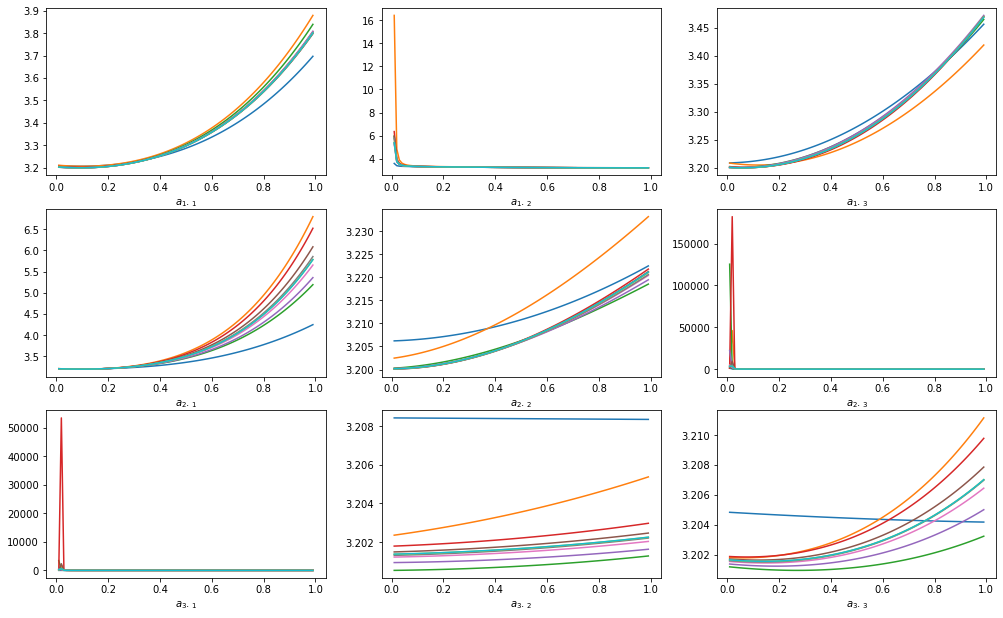

In [14]:
def verify_gradient_a(i, j, P = P, A = A):
    print(f"{i} {j}, ..., ", end = " ")
    p_list = np.linspace(0.01, 0.99, 100)
    results = [[], []]
    
    p_temp = P[i - 1][j - 1]
    
    for p in p_list:
        P[i - 1][j - 1] = p
        results[0].append(expected_cost_2(A, P, As, Ps))
        
    P[i - 1][j - 1] = p_temp

    plt.xlabel(f"$a_{i}._{j}$")
    
    # print(f"Setting P[{i}][{j}] to optimum {0.01 + 0.98 * np.argmin(results[0]) / 100}")
    P[i - 1][j - 1] = 0.01 + 0.98 * np.argmin(results[0]) / 100

    plt.plot(p_list, results[0])        

# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# create figure
fig = plt.figure(1)

# set variables
A, P = As.copy(), Ps.copy()

# verify gradient for all entries in A
for _ in range(10):
    for k in range(n ** 2):
        # add every single subplot to the figure with a for loop    
        ax = fig.add_subplot(n, n, position[k])
        verify_gradient_a(k // n + 1, k % n + 1, P = P, A = As)

        P = sinkhorn_balance(P)

# plt.show()

A_hat_2 = np.tril(np.matmul(np.linalg.inv(P), np.matmul(A, P)))
print(expected_cost(A, P))

print(A)
print(As)

In [12]:
def sinkhorn_balance(P):
    for _ in range(10):
        # normalize rows
        r_sum = P.sum(axis=1)
        P = P / r_sum[:, np.newaxis]
        
        
        c_sum = P.sum(axis = 0)
        P = P / c_sum
    return P

print(sinkhorn_balance(np.array([[0.1, 0.2], [0.2, 0.3]])))

[[0.46410162 0.53589838]
 [0.53589838 0.46410162]]


In [13]:
def verify_gradient_a(i, j, P = P, A = A):
    print(f"{i} {j}, ..., ", end = " ")
    a_list = np.linspace(-2, 2, 5000)
    results = [[], []]
    
    a_temp = A[i - 1][j - 1]
    
    for a in a_list:
        A[i - 1][j - 1] = a
        results[0].append(expected_cost(A, P, As, Ps))
        results[1].append(B_grad_a(A, P, i - 1, j - 1))
        
    A[i - 1][j - 1] = a_temp

    plt.xlabel(f"$a_{i}._{j}$")
    
#     print(f"Setting A[{i}][{j}] to optimum {-2 + 4 * np.argmin(results[0]) / 5000}")
#     A[i - 1][j - 1] = -2 + 4 * np.argmin(results[0]) / 5000
    
    if i == 1 and j == 1:
        plt.plot(a_list, results[0], label = r"$C(a_{ij})$")
        plt.plot(a_list, results[1], label = r"$\frac{\partial C(a_{ij})}{\partial a_{ij}}$")
        plt.plot([-2, 2], [0, 0], linestyle = '--', label = r"$y = 0$")
        plt.vlines(a_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(a_{ij})$", color = 'black')
        plt.vlines(A[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{a}_{ij}$", color = 'blue') 
    else:
        plt.plot(a_list, results[0])
        plt.plot(a_list, results[1])
        plt.plot([-2, 2], [0, 0], linestyle = '--')
        plt.vlines(a_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', color = 'black')
        plt.vlines(A[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', color = 'blue')

1 1, ...,  1 2, ...,  1 3, ...,  2 1, ...,  2 2, ...,  2 3, ...,  3 1, ...,  3 2, ...,  3 3, ...,  

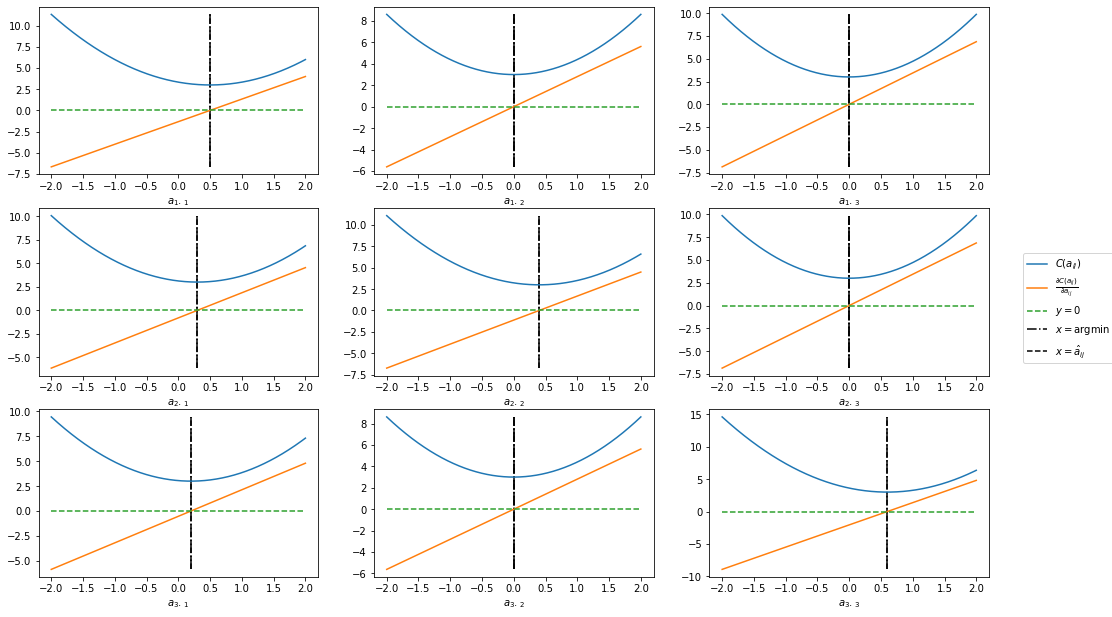

In [13]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# create figure
fig = plt.figure(1)

# set variables
A, P = As.copy(), np.identity(n)

# verify gradient for all entries in A
for k in range(n ** 2):
    # add every single subplot to the figure with a for loop    
    ax = fig.add_subplot(n, n, position[k])
    verify_gradient_a(k // n + 1, k % n + 1, P = P, A = A)

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

1 1, ...,  1 2, ...,  1 3, ...,  2 1, ...,  2 2, ...,  2 3, ...,  3 1, ...,  3 2, ...,  3 3, ...,  

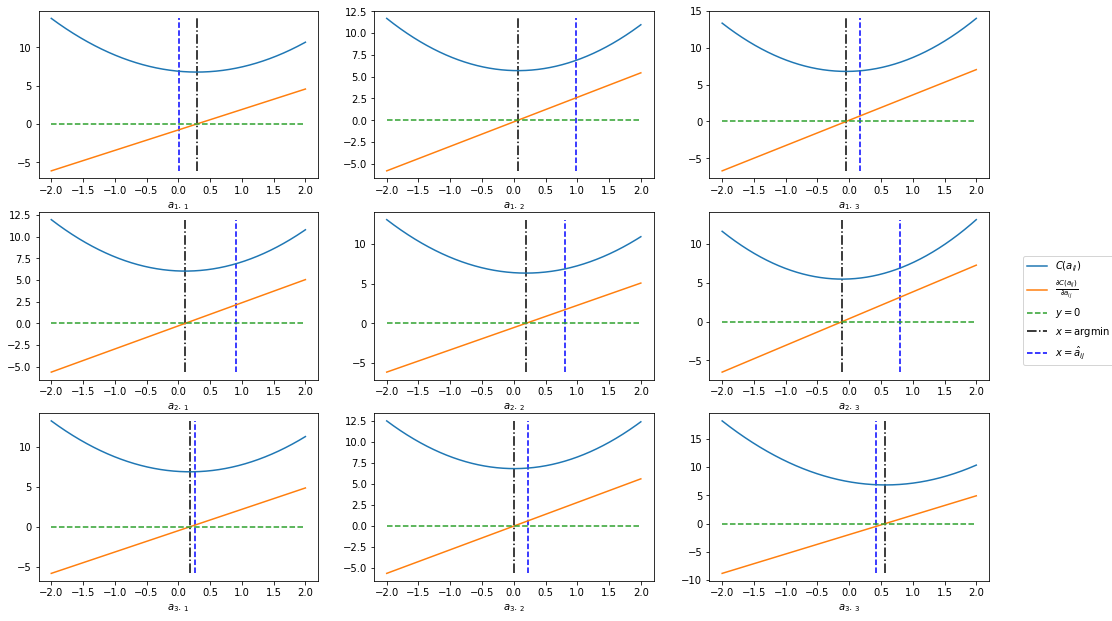

In [15]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# create figure
fig = plt.figure(1)

# set variables
A, P = np.random.rand(n, n), np.identity(n)

# verify gradient for all entries in A
for k in range(n ** 2):
    # add every single subplot to the figure with a for loop    
    ax = fig.add_subplot(n, n, position[k])
    verify_gradient_a(k // n + 1, k % n + 1, P = P, A = A)

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

### Verify gradient of $P$ for $A = A^*$ and $P = P^*$

In [26]:
def verify_gradient_p(i, j, P = P, A = A):
    print(f"{i} {j}, ..., ", end = " ")
    p_list = np.linspace(-0.01, 0.99, 100)
    results = [[], []]
    
    p_temp = P[i - 1][j - 1]
    
    for p in p_list:
        P[i - 1][j - 1] = p
        results[0].append(expected_cost(A, P, As, Ps))
        results[1].append(B_grad_p(A, P, i - 1, j - 1))
        
    P[i - 1][j - 1] = p_temp

    for a in range(2):
        for b in range(100):
            if abs(results[a][b] ) > 8.000:
                results[a][b] = np.sign(results[a][b]) * 8.000
            
    plt.xlabel(f"$p_{i}._{j}$")
    
    # plt.ylim(-4.500,4.500)
    if i == 1 and j == 1:
        plt.plot(p_list, results[0], label = r"$C(p_{ij})$")
        plt.plot(p_list, results[1], label = r"$\frac{\partial C(p_{ij})}{\partial p_{ij}}$")
        plt.plot([0, 1], [0, 0], linestyle = '--', label = r"$y = 0$")
        plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(p_{ij})$", color = 'black')
        plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{p}_{ij}$")
    else:
        plt.plot(p_list, results[0])
        plt.plot(p_list, results[1])
        plt.plot([0, 1], [0, 0], linestyle = '--')
        plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', color = 'black')
        plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--')

1 1, ...,  1 2, ...,  1 3, ...,  2 1, ...,  2 2, ...,  2 3, ...,  3 1, ...,  3 2, ...,  3 3, ...,  

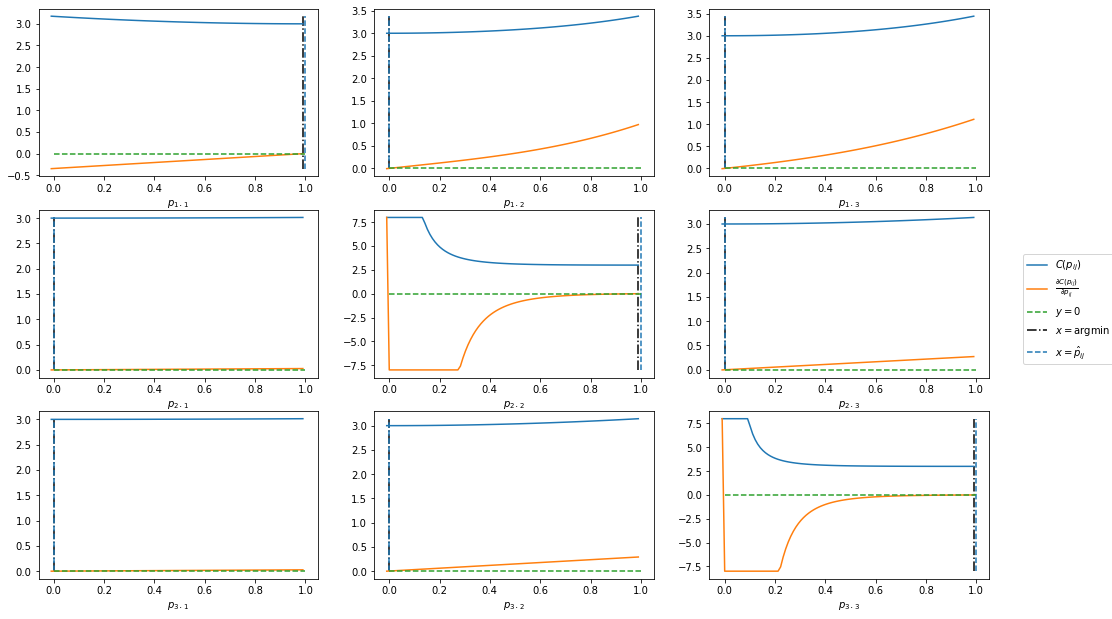

In [27]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# create figure
fig = plt.figure(1)

# set variables
A, P = As.copy(), Ps.copy()

# verify gradient for all entries in A
for k in range(n ** 2):
    # add every single subplot to the figure with a for loop    
    ax = fig.add_subplot(n, n, position[k])
    verify_gradient_p(k // n + 1, k % n + 1, P = P, A = A)

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

1 1, ...,  1 2, ...,  1 3, ...,  2 1, ...,  2 2, ...,  2 3, ...,  3 1, ...,  3 2, ...,  3 3, ...,  

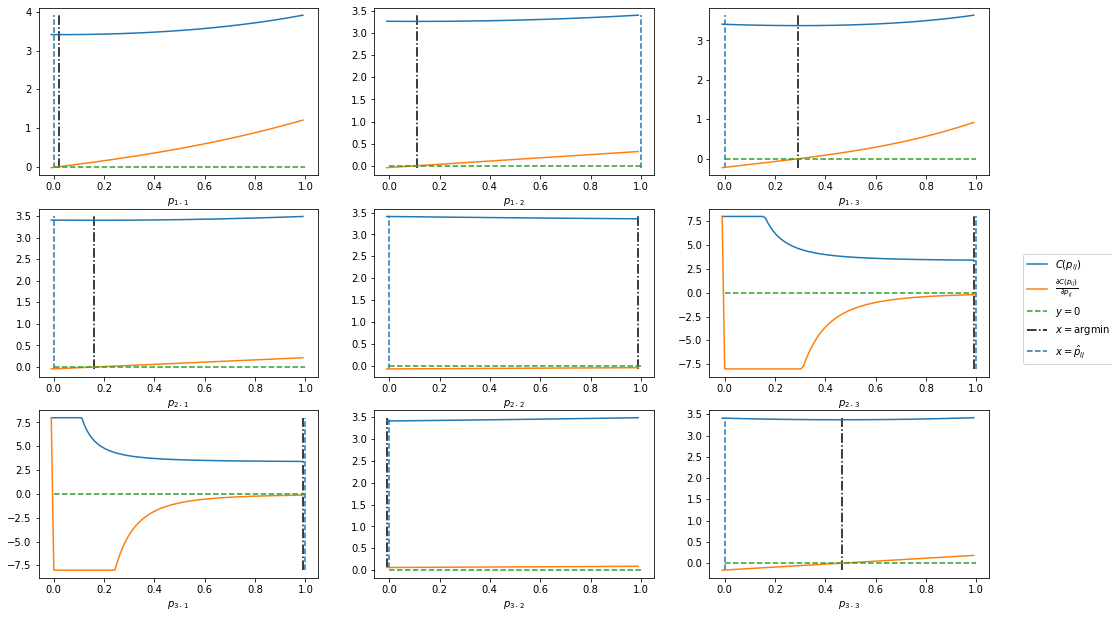

In [28]:
# Create a Position index
plt.figure(figsize = (3 * n + 3, 3 * n))
plt.subplots_adjust(bottom = 0.0, left = -0.2)
position = range(1, n ** 2 + 1)

# create figure
fig = plt.figure(1)

# set variables
A, P = As.copy(), np.array([[0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0]])

# verify gradient for all entries in A
for k in range(n ** 2):
    # add every single subplot to the figure with a for loop    
    ax = fig.add_subplot(n, n, position[k])
    verify_gradient_p(k // n + 1, k % n + 1, P = P, A = A)

fig.legend(loc = 'right', ncol = 1, borderaxespad = -3.0)
plt.show()

In [76]:
def top_sort(A):
    """Input, WAM A"""
    # We do not take self-loops into account
    WAM = A.copy()
    np.fill_diagonal(WAM, 0)
    
    top_order = np.array([])
    
    # iterative remove the row with no zeros
    while len(top_order) != WAM.shape[0]:
        print(WAM)
        # find row with zeros
        for i in range(WAM.shape[0]):
            print(top_order)
            if np.all((WAM[i] == 0)) and i not in top_order:
                top_order = np.append(top_order, i)
                
                # remove all entries in the row and column
                WAM[i] = 0
                WAM[:,i] = 0  
                
        
    return top_order

print(A)
perm = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]])
A2 = A
print(A2)
top_sort(A)

[[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.  0.6]]
[[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.  0.6]]
[[0.  0.  0. ]
 [0.3 0.  0. ]
 [0.2 0.  0. ]]
[]
[0.]
[0. 1.]


array([0., 1., 2.])

In [93]:
print("Expected Cost when using P* and A* full rank:", np.trace(Sigma))

n = 2
import itertools
np.random.seed(3)
A = np.tril(np.round(np.random.rand(n, n) / 2, 2))
print(A)
P_list = np.array(list(itertools.permutations(np.identity(n))))

for i in range(len(P_list)):
    P2 = np.array(P_list[i])
    P_inv = np.linalg.inv(P2)
    print((np.matmul(A, P2)))
    # print("Expected Cost when using A:", expected_cost_2(A, np.array(P_list[i])))

Expected Cost when using P* and A* full rank: 3.0
[[0.28 0.  ]
 [0.15 0.26]]
[[0.28 0.  ]
 [0.15 0.26]]
[[0.   0.28]
 [0.26 0.15]]


## Try to find $A^*$ and $P^*$ iteratively

In [145]:
def set_gradient_a(i, j, P = P, A = A):
    print(f"{i} {j}, ..., ", end = " ")
    a_list = np.linspace(-2, 2, 200)
    results = [[], []]
    
    a_temp = A[i - 1][j - 1]
    
    for a in a_list:
        A[i - 1][j - 1] = a
        results[0].append(expected_cost(A, P, As, Ps))
        results[1].append(B_grad_a(A, P, i - 1, j - 1))
        
    A[i - 1][j - 1] = a_temp
    
    print(f"Setting A[{i}][{j}] to optimum {-2 + 4 * np.argmin(results[0]) / 200}")
    if j <= i:
        A[i - 1][j - 1] = -2 + 4 * np.argmin(results[0]) / 200
    else:
        A[i - 1][j - 1] = 0

In [103]:
def set_gradient_p(i, j, P = P, A = A):
    print(f"{i} {j}, ..., ", end = " ")
    p_list = np.linspace(0.01, 0.99, 100)
    results = [[], []]
    
    p_temp = P[i - 1][j - 1]
    
    for p in p_list:
        P[i - 1][j - 1] = p
        results[0].append(expected_cost(A, P, As, Ps))
        results[1].append(B_grad_p(A, P, i - 1, j - 1))
        
    P[i - 1][j - 1] = p_temp
    
    print(f"Setting P[{i}][{j}] to optimum {0.01 + 0.98 * np.argmin(results[0]) / 100}")
    P[i - 1][j - 1] = 0.01 + 0.98 * np.argmin(results[0]) / 100

In [150]:
# start with random initializations (e.g. A zero, P close to J / n)
A = np.zeros((n, n))
P = np.ones((n, n)) / (1.1 * n) + np.identity(n) / (11)

# iterativel set A[i][j], P[i][j] to argmin C
for k in range(n ** 2):
    set_gradient_a(k // n + 1, k% n + 1, P, A)
for k in range(n ** 2):
    set_gradient_p(k // n + 1, k% n + 1, P, A)

# sinkhorn balance P to make sure P is DS
print(expected_cost(A, P))

1 1, ...,  Setting A[1][1] to optimum 0.06000000000000005
1 2, ...,  Setting A[1][2] to optimum 0.0
1 3, ...,  Setting A[1][3] to optimum 0.0
2 1, ...,  Setting A[2][1] to optimum -0.020000000000000018
2 2, ...,  Setting A[2][2] to optimum 0.0
2 3, ...,  Setting A[2][3] to optimum 0.0
3 1, ...,  Setting A[3][1] to optimum 0.0
3 2, ...,  Setting A[3][2] to optimum 0.0
3 3, ...,  Setting A[3][3] to optimum 0.0
1 1, ...,  Setting P[1][1] to optimum 0.3922
1 2, ...,  Setting P[1][2] to optimum 0.2844
1 3, ...,  Setting P[1][3] to optimum 0.3432
2 1, ...,  Setting P[2][1] to optimum 0.2746
2 2, ...,  Setting P[2][2] to optimum 0.3922
2 3, ...,  Setting P[2][3] to optimum 0.304
3 1, ...,  Setting P[3][1] to optimum 0.2844
3 2, ...,  Setting P[3][2] to optimum 0.2942
3 3, ...,  Setting P[3][3] to optimum 0.4118
4.580888956032038


In [159]:
A, P = As.copy(), Ps.copy()

for _ in range(10):
    # iterativel set A[i][j], P[i][j] to argmin C
    for k in range(n ** 2):
        set_gradient_a(k // n + 1, k % n + 1, P, A)
    for k in range(n ** 2):
        set_gradient_p(k // n + 1, k % n + 1, P, A)
        P = sinkhorn_balance(P)

# sinkhorn balance P to make sure P is DS
print(P)
print(A)
print(expected_cost(A, P))
print(Ps)
print(As)

1 1, ...,  Setting A[1][1] to optimum 0.48
1 2, ...,  Setting A[1][2] to optimum 0.0
1 3, ...,  Setting A[1][3] to optimum 0.0
2 1, ...,  Setting A[2][1] to optimum 0.2799999999999998
2 2, ...,  Setting A[2][2] to optimum 0.3999999999999999
2 3, ...,  Setting A[2][3] to optimum 0.0
3 1, ...,  Setting A[3][1] to optimum 0.18000000000000016
3 2, ...,  Setting A[3][2] to optimum 0.2999999999999998
3 3, ...,  Setting A[3][3] to optimum 0.5800000000000001
1 1, ...,  Setting P[1][1] to optimum 0.01
1 2, ...,  Setting P[1][2] to optimum 0.9802
1 3, ...,  Setting P[1][3] to optimum 0.01
2 1, ...,  Setting P[2][1] to optimum 0.019799999999999998
2 2, ...,  Setting P[2][2] to optimum 0.0394
2 3, ...,  Setting P[2][3] to optimum 0.941
3 1, ...,  Setting P[3][1] to optimum 0.941
3 2, ...,  Setting P[3][2] to optimum 0.1766
3 3, ...,  Setting P[3][3] to optimum 0.01
1 1, ...,  Setting A[1][1] to optimum 0.5
1 2, ...,  Setting A[1][2] to optimum 0.0
1 3, ...,  Setting A[1][3] to optimum 0.0
2 1, ...

2 2, ...,  Setting A[2][2] to optimum 0.2999999999999998
2 3, ...,  Setting A[2][3] to optimum -0.020000000000000018
3 1, ...,  Setting A[3][1] to optimum 0.06000000000000005
3 2, ...,  Setting A[3][2] to optimum 0.18000000000000016
3 3, ...,  Setting A[3][3] to optimum 0.5
1 1, ...,  Setting P[1][1] to optimum 0.26480000000000004
1 2, ...,  Setting P[1][2] to optimum 0.6372
1 3, ...,  Setting P[1][3] to optimum 0.3432
2 1, ...,  Setting P[2][1] to optimum 0.1962
2 2, ...,  Setting P[2][2] to optimum 0.1472
2 3, ...,  Setting P[2][3] to optimum 0.647
3 1, ...,  Setting P[3][1] to optimum 0.451
3 2, ...,  Setting P[3][2] to optimum 0.49019999999999997
3 3, ...,  Setting P[3][3] to optimum 0.059000000000000004
[[0.2616841  0.44464028 0.29367562]
 [0.22821498 0.12501671 0.64676832]
 [0.51010092 0.43034301 0.05955606]]
[[0.64 0.   0.  ]
 [0.38 0.3  0.  ]
 [0.06 0.18 0.5 ]]
3.035699537499707
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
[[0.5 0.  0. ]
 [0.3 0.4 0. ]
 [0.2 0.3 0.6]]


In [96]:
aparms = int(n * (n + 1) / 2)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def inv_sigmoid(x):
    return np.log(x/(1-x))

def expected_cost_opt(variables):
    # create A
    A = np.zeros((n, n))
    A[np.tril_indices(n)] = variables[:aparms]
    
    # create P
    P = np.array(sigmoid(variables[aparms:])).reshape(n, n)
    
    ## compute expected cost
    # compute inverses
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    # compute B
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    # compute covariance of X
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    
    # compute covariance of X_{val} - X_{pred}
    covariance_matrix = Sigma + np.matmul((Bs - B), np.matmul(covariance_X, (Bs - B).transpose()))
    
    # return cost
    return np.trace(covariance_matrix)

# set dimension
n = 3

# set A
A = np.tril((np.random.rand(n, n)))

# set P
P = np.array([[100, -100, -100], [-100, 100, -100], [-100, -100, 100]])

# define variables
variables = np.append(A[np.tril_indices(n)], P.flatten())

# compute expected cost
expected_cost_opt(variables)

4.910240095462455

In [280]:
def eq_cons_ij(variables):
    P = np.array(sigmoid(variables[aparms:])).reshape((n, n))[0]
    return sum(P) - 1

def eq_cons_2(variables):
    P = np.array(sigmoid(variables[aparms:])).reshape((n, n))[1]
    return sum(P) - 1

def eq_cons_3(variables):
    P = np.array(sigmoid(variables[aparms:])).reshape((n, n))[2]
    return sum(P) - 1

def eq_cons_4(variables):
    P = np.array(sigmoid(variables[aparms:])).reshape((n, n))[:, 0]
    return sum(P) - 1

def eq_cons_5(variables):
    P = np.array(sigmoid(variables[aparms:])).reshape((n, n))[:, 1]
    return sum(P) - 1

def eq_cons_6(variables):
    P = np.array(sigmoid(variables[aparms:])).reshape((n, n))[:, 2]
    return sum(P) - 1

cons = [{'type': 'eq', 'fun': eq_cons_1}, {'type': 'eq', 'fun': eq_cons_2}, {'type': 'eq', 'fun': eq_cons_3},
        {'type': 'eq', 'fun': eq_cons_4}, {'type': 'eq', 'fun': eq_cons_5}, {'type': 'eq', 'fun': eq_cons_6}]

In [408]:
from scipy import optimize
x0 = np.random.rand(aparms + n ** 2)
# x0[aparms:] = np.identity(n).flatten()

results = optimize.minimize(expected_cost_opt, x0, constraints = cons)
attempts = 0
broken_attempts = 0
while results.fun > 3.05 or results.fun < 0:
    attempts += 1
    print(results.fun)
    x0 = np.random.rand(aparms + n ** 2)
    try:
        results = optimize.minimize(expected_cost_opt, x0, constraints = cons)
    except:
        broken_attempts += 1
        print("Error")

print(x0)
print(results.fun)
A_pred = np.zeros((n, n))
A_pred[np.tril_indices(n)] = results.x[:aparms]
P_pred = results.x[aparms:]

print("Attempts:", attempts)
print("Errored attempts:", broken_attempts)

print(np.round(A_pred, 2))
print(np.round(sigmoid(P_pred).reshape((n, n)), 2))

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in matmul


65966842.104388915
4741245.861192919
Error
4741245.861192919
10218711.737100739
846312159.7848815
291879142.6748691
229195394.50216937
241464187.9739421
4198539.9539028
34922238.27474269
18202545.301411666
4503382.539189875
14455374.605984751
3379276.3632748956
237205.66543512736
2132141.3898223564
26546876052689.883
Error
26546876052689.883
1876612.6660017746
6348494.165233975
709146316.228814
8437340032.730623
4295634.073931074
Error
4295634.073931074
28526722.86765469
Error
28526722.86765469
Error
28526722.86765469
350598216984.3885
6364374905.521114
240392572521.56888
108748759.83112931
3183633026.730459
2389414863860.495
133398.36676109204
Error
133398.36676109204
Error
133398.36676109204
2240399861.534728
362820609.2297303
186824.1957978745
12290809129.61738
800653688.3864169
8353162.440839414
36011983.7943832
Error
36011983.7943832
2580630057.478712
2102258559724.4434
2563261.682337373
1275167.5747133659
854922.6556856894
6448699463.751541
1577077289.4566846
104353863.43011226
2

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in matmul


2309983.6079091406
3759864.786559386
24340.384528637944
Error
24340.384528637944
1008057.5781054567
14302.105820432242
3306949.46723107
7584275.23159883
2287521.573430782
113758383.87479456
258140093.03691512
2407289.1349563655
213580601.41972247
574944377.5362848
94906890800.87817
347318.5147306414
37951934.96149771
995799747.8763268
2371537280.6745253
Error
2371537280.6745253
9545.329399087981
303698082748129.25
8940.962551781564
2092487.2643803488
Error
2092487.2643803488
89101.82555620171
31634.74341399857
5300176.265812925
500926986.0412438
6038578698.5419
13043373.463890731
19791162594.574432
334.34730711945485
4396691.939626064
3148534.056536653
464134.55563588074
1787336718414.8818
51828054.377983674
50497790214.436066
898496899.2885906
1036988445.5377178
8740094760.541069
1473205.3458589322
37976550.292764395
7715380372.267317
Error
7715380372.267317
235604970018.32443
Error
235604970018.32443
1563449.109100959
Error
1563449.109100959
95298297.21918693
9322553.872898247
10405.

6704404.182486473
933797087.9258949
1150622566364.1602
19356312163.997597
Error
19356312163.997597
282737942.94336206
883902814.1885194
50317382.214820996
30655811.129321665
164565895.90729612
4984250.098029464
98368.0509453078
1756824.3342222122
110810892.38298534
Error
110810892.38298534
43413311.38478861
10105290.39310646
11582900480.026392
39388105.47092889
Error
39388105.47092889
298229147.69725454
396688.18813049776
96.68400431301981
21136.715235698677
652647.6569631575
342029845.5734582
Error
342029845.5734582
587.5834511783694
Error
587.5834511783694
180444645429.54047
213323842.55970287
2532208.104165645
39768943105.756424
1427656.0302190897
48332383196.03754
424939.87904661975
856784959722.0859
12012164.129388751
3645578.0160946185
22425589482.562637
Error
22425589482.562637
45685626561950.57
Error
45685626561950.57
Error
45685626561950.57
27510249162934.105
Error
27510249162934.105
Error
27510249162934.105
989820.3407058591
5785231.043911515
8543444.341011936
15346099984.534

1828496.1958523928
292755972876.7262
48993902.6285962
290768.99507971865
630154.8851449953
Error
630154.8851449953
60088794.16439251
153080777893.0423
12771153.728237439
Error
12771153.728237439
15357627801.343464
5288555.86744978
5040266392.513655
8514.211291922526
5200763000.412705
Error
5200763000.412705
628813.525773651
24129056.38393225
4585323.461168225
2868679.308917553
Error
2868679.308917553
7485899.615829958
213648464.18335116
Error
213648464.18335116
2743003482791.076
630924100.9627413
11084838954577.922
6442113.588574676
1417013355.3772619
745391000988.1086
5107.709005190593
Error
5107.709005190593
Error
5107.709005190593
3154926.6760026235
351176587.5029533
372944194.4148273
4334453.112232209
192869.94267663144
515160.3752726215
626405.2547195411
51917744.87730451
32562636.631871395
15185636696.665228
448541002.370336
407619011.35285974
7196046606.670874
165044996.5674671
627367280.5402986
2104687.732828234
35286553.46380799
69603088207433.69
Error
69603088207433.69
114241

8815.182333198863
474922.2884767912
1923531976497.9617
16273.959937207386
Error
16273.959937207386
34884367.98010306
Error
34884367.98010306
132188355908.6199
132417.79944361933
Error
132417.79944361933
Error
132417.79944361933
6768762.942856211
36243359887.01323
8582677.172795516
1071680.7403713628
2079244.1521315346
78760.23137518321
Error
78760.23137518321
Error
78760.23137518321
9078812235.160961
114432.3500127558
792861252856.2428
7727710.665239908
435806893.15742713
1001738.7481716732
9293784.27535551
3653740666.7607803
26609822.640416972
Error
26609822.640416972
Error
26609822.640416972
3.109930520780053
896378981.3025798
37989760.668133
109626.51930286484
4883341.234539688
Error
4883341.234539688
206582480.07411587
64857191.74079168
926399.8411703882
6146016562.737352
3507460259.3008947
1017774702.3703945
628271.6393722352
24423.810988497353
Error
24423.810988497353
17546294.93511396
1648002.0366029888
111920651.52676849
5263185.945060585
12925541.90152616
463315.9753847373
Err

5076805.503197108
120193321.45605876
Error
120193321.45605876
75676716.01062404
Error
75676716.01062404
5948434365.05005
17950250104763.918
638720029.4888475
33713572.8358421
25248.779443856263
41652660400.54849
9600.737749477858
138084445540.65857
5606620.000006345
27773584.31703245
39284228728.88316
Error
39284228728.88316
1029340819.9725065
26661915.61487586
492298.6357573528
754108929.718555
287100.2250751273
3827586.6680271598
Error
3827586.6680271598
Error
3827586.6680271598
3351393.2055792464
Error
3351393.2055792464
4806218.31064818
14846335509.96816
5993459879.900589
5205444708.623324
14358016.914032083
Error
14358016.914032083
Error
14358016.914032083
876266.3844335846
503749.82718586375
Error
503749.82718586375
98863223.3344536
154003896.28907666
Error
154003896.28907666
1620082.217446786
163355885.82441568
5646637986638.673
428153728.06884664
Error
428153728.06884664
411772.35015998443
Error
411772.35015998443
Error
411772.35015998443
1653126880.1739447
3622447.609271044
68

5.6186934302768865
22615599.61936912
14074423.7147765
Error
14074423.7147765
65918462.50201519
24005830.25725901
122867494.87981893
1231345.2395917026
125904374.77516356
7666175.530279228
661092.6743047402
2101983.5980177377
Error
2101983.5980177377
Error
2101983.5980177377
415.03984108238035
29159266.48537064
2208302486.4417706
4902824.390760671
Error
4902824.390760671
Error
4902824.390760671
156379270223.68793
11886465968.97804
Error
11886465968.97804
5093058.848772253
1168180.2420362814
45683083.35289378
778503839.6682175
147407491.51417357
41088809.78032316
9402781011.085669
8654697.320341434
23579286.60524752
319890376.91196984
19810292.660266135
26338612.03006439
643886569.8495674
297077.9806553355
14107699758.669113
23976035630.8376
24168008.87667529
Error
24168008.87667529
37688.68416684346
12852814.403623449
2735358.0943150646
5900626.94491512
1758046.5980893972
103697102.05126753
164417.49818267114
374243.7566336015
327821.5647136996
688102251.7734761
174505038.65107423
Error

4567021326173.272
713327726.9349686
11107438.387971893
103844539.84515277
99182942.0083143
3767952.75201237
Error
3767952.75201237
107815812.08716412
3375.076551100052
152752.11334490625
1527748.1566783655
33374268013132.445
22902836213.440136
12268104219042.129
22029939.601276368
8500.039808185284
58.60293923081986
6478177015.335005
433791727.77305675
7259516.788928754
25660907.79816112
52024.630383321455
Error
52024.630383321455
198944872.5510061
606955.7405443974
24826.148111328926
100150245.54668419
176054282.38515985
39110.62190415492
7387027.42859774
502602044.407212
69638682.38080433
Error
69638682.38080433
98820746.63854587
312384.95684891543
20203681465912.88
Error
20203681465912.88
14024459.370764658
Error
14024459.370764658
2021628.1625142714
4087670.9777161884
Error
4087670.9777161884
1448301456.4208126
179992.58653956835
167701.298514696
Error
167701.298514696
8802193773.132101
283056.6847310989
50467015459.07095
2552073.8636836745
278288.14898725133
904659.0771604985
6202

C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in matmul
C:\Users\s165048\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in matmul


1355539188.0257342
1665641378.3011842
Error
1665641378.3011842
3591066.004088786
263424751.4330931
1832622225.7321873
2958711016556.274
44561.82727913702
492985.8740657272
42343243970.05947
70441704950.43585
6832068.5270100655
Error
6832068.5270100655
7782970700525.358
Error
7782970700525.358
850693559.4116392
15870828.573836545
Error
15870828.573836545
23276136.560895864
Error
23276136.560895864
2482652647.180851
571273.0001974626
18362533629358.715
417678810.15842086
2888536.775928612
1075550.101747705
9832463509.326092
14422806.761966925
Error
14422806.761966925
7729530.737227939
185528326519.393
6788536.9151977
285939.29321378993
11649382387.22903
1228219.535070747
1560995978.6496394
2312688003872.9277
188600924583.64114
56154943.080782495
156544516.40322506
114504145.94565119
98179746.14871684
48523623.85875206
542012249.4023281
293426042.5910665
465580.36009272275
1083372.424725771
3938427275.4321227
1565656635.426761
10114101.426275173
5532020.144760996
Error
5532020.144760996
E

448910.19874101144
9042585.283205256
53652825.80297622
81284442556.2028
Error
81284442556.2028
1640420.424991759
273866.1702620931
112628.31984484062
34998951.99158445
64414259784.40584
3325455123272.911
14360989501644.25
88825256049.47385
Error
88825256049.47385
980592688.5063971
Error
980592688.5063971
3470528.595372406
56416219.621417
25944838.709163453
Error
25944838.709163453
5983261.229791318
42728558.30289691
96758260.03599024
Error
96758260.03599024
248684596.81301752
Error
248684596.81301752
98079133.48103115
4595872025.159866
37219102.89091736
596370676970.5708
Error
596370676970.5708
2103165354433.0369
31911423.636839703
558944033.1154444
16616330.045421787
1332900.4502637202
Error
1332900.4502637202
37979683932.65143
28866346.359306518
135594242.4170672
36164930.778144166
2094415.2469479602
44750652450.62803
15014998970.064285
445274913.9200139
85286956.55522497
3127199535.5898113
53958548.6233961
4757826758.15475
Error
4757826758.15475
23914764579.754417
53510.31550112326


79858377.6117619
124204211264.68376
133328.0831992358
Error
133328.0831992358
5867.286833380216
Error
5867.286833380216
21079016127.17881
38272793.20810599
292279511053.8351
1729414.1424860694
1736020.6120115104
521958039.56899995
8363438.5062332
Error
8363438.5062332
36162.65435718308
53432122.98210791
Error
53432122.98210791
1501793.4405282135
3982.0481309848137
392176.93550990487
Error
392176.93550990487
3927555172.2820086
Error
3927555172.2820086
11467420.72438566
308983374.6853243
2512420.1516581727
218629988.12541273
2802.3700631902493
87.5587049879386
97944.43750482782
759725170.356727
1331567965795.8125
803743976.8748851
111685840.1599009
120364572.95253341
Error
120364572.95253341
13151191.535622189
195840842.06760883
11241974.04254793
30078152465.170616
4990837.369596941
5275744910.197329
5744116.467582908
Error
5744116.467582908
729672286.6377441
Error
729672286.6377441
81495863.18347016
60790.33940335564
124070335.42405713
Error
124070335.42405713
225644.04028840177
Error
2

2398.2675017161787
Error
2398.2675017161787
7190937930.181532
Error
7190937930.181532
2100628261.990705
3.180140090442767
14659702544.687927
2503310.4603728536
2564732311.293478
239148.26417101081
68896536.91517647
127114979936680.06
20642559967.89983
52938335.07493519
2923.139932627481
52423404.24098801
27329658725.71808
756960336.9419123
5948389.763073203
298495.88412611274
10232193.519592084
Error
10232193.519592084
285483.3572398885
Error
285483.3572398885
Error
285483.3572398885
780184.735818608
Error
780184.735818608
Error
780184.735818608
21921928.821298853
Error
21921928.821298853
Error
21921928.821298853
1199236.0997577047
1181153639.3211405
16131283388.876081
420534563.9809402
18152390.263832435
2156989.390125054
316095.875419308
Error
316095.875419308
8906757.074032592
425066.20473711746
2334347.402134157
98.96114106555169
3154178.670679492
12855987.26093521
269641667426.97403
360.5611609165378
3713563885.956673
42740160.23761303
Error
42740160.23761303
19752102597.891968
13

125079575.72502367
1266533.9994288525
935311412854.3818
3087156128674.9707
3801240.4156324184
8267031.315346267
7839446779.174934
14488977.094461162
99870525.15084454
Error
99870525.15084454
1162176923.0691845
19907975.495340634
3.3163481663263203
8981703.40927443
433894760.5581996
2183.51096356481
3.168359041602063
13900072.649002353
40427662.455013886
87756373.3283928
1851012.6877437308
17514219.31001892
86154.39886876939
130327701400.59238
33275362.075965043
1590489.3719276949
1104905301.0187082
103151032.55354974
134965.96092290583
Error
134965.96092290583
6958.393464789405
246608304.1892499
28588901902.650955
2689302.510006426
11404.414781230687
4907779008471.807
85.18811804487024
105244345.81960692
1864.3456249563687
342987.2457327619
5769262.2476264285
10167908.991320826
Error
10167908.991320826
240454169.1459558
7708444342.402954
7261354.762097732
220405597.6569391
663338.6043685206
130326075.22638214
7215787.317448499
Error
7215787.317448499
21526833.703597456
14008968.9850523

In [409]:
variables_2 = results.x
results_2 = optimize.minimize(expected_cost_opt, variables_2, constraints = cons)
print(results_2)

     fun: 3.000002428316388
     jac: array([-2.53319740e-06,  1.60336494e-05, -1.47223473e-05, -1.40070915e-05,
       -1.46627426e-05,  1.13248825e-05,  5.48362732e-06,  0.00000000e+00,
       -6.55651093e-07,  0.00000000e+00,  0.00000000e+00, -5.96046448e-08,
        5.96046448e-08,  0.00000000e+00,  0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 89
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([  0.50313115,   0.30162259,   0.39732725,   0.19890811,
         0.29982063,   0.59934298,  -5.71055772,   4.48970731,
        -4.84587203, -12.7779164 ,  -4.80678081,   4.80642992,
         5.70969995,  -5.80898657,  -8.07466986])
